# Optional Lab: Gradient Descent for Logistic Regression

## Goals
이 실습에서는 다음을 수행합니다.
- 로지스틱 회귀를 위한 경사하강법을 업데이트합니다.
- 친숙한 데이터 세트에서 경사하강법을 살펴봅니다.

In [ ]:
import copy, math
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
from lab_utils_common import  dlc, plot_data, plt_tumor_data, sigmoid, compute_cost_logistic
from plt_quad_logistic import plt_quad_logistic, plt_prob
plt.style.use('./deeplearning.mplstyle')

## Data set 
결정 경계 실습에서 사용된 것과 동일한 두 가지 특징 데이터 세트부터 시작해 보겠습니다.

In [ ]:
X_train = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_train = np.array([0, 0, 0, 1, 1, 1])

이전과 마찬가지로 도우미 함수를 사용하여 이 데이터를 플롯합니다. $y=1$ 레이블이 있는 데이터 포인트는 빨간색 십자가로 표시되고 $y=0$ 레이블이 있는 데이터 포인트는 파란색 원으로 표시됩니다.

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,4))
plot_data(X_train, y_train, ax)

ax.axis([0, 4, 0, 3.5])
ax.set_ylabel('$x_1$', fontsize=12)
ax.set_xlabel('$x_0$', fontsize=12)
plt.show()

## Logistic Gradient Descent
<img align="right" src="./images/C1_W3_Logistic_gradient_descent.png"     style=" width:400px; padding: 10px; " >

경사하강법 알고리즘은 그라디언트 계산을 활용함을 기억하십시오:
$$\begin{align*}
&\text{repeat until convergence:} \; \lbrace \\
&  \; \; \;w_j = w_j -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial w_j} \tag{1}  \; & \text{for j := 0..n-1} \\ 
&  \; \; \;  \; \;b = b -  \alpha \frac{\partial J(\mathbf{w},b)}{\partial b} \\
&\rbrace
\end{align*}$$

각 반복은 모든 $j$에 대해 $w_j$에 대한 동시 업데이트를 수행합니다. 여기에서
$$\begin{align*}
\frac{\partial J(\mathbf{w},b)}{\partial w_j}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)})x_{j}^{(i)} \tag{2} \\
\frac{\partial J(\mathbf{w},b)}{\partial b}  &= \frac{1}{m} \sum\limits_{i = 0}^{m-1} (f_{\mathbf{w},b}(\mathbf{x}^{(i)}) - y^{(i)}) \tag{3} 
\end{align*}$$

* m은 데이터 세트의 훈련 예제 수입니다.
* $f_{\mathbf{w},b}(x^{(i)})$는 모델의 예측이고 $y^{(i)}$는 타겟입니다.
* 로지스틱 회귀 모델의 경우
     $z = \mathbf{w} \cdot \mathbf{x} + b$
     $f_{\mathbf{w},b}(x) = g(z)$
     여기서 $g(z)$는 시그모이드 함수입니다.
     $g(z) = \frac{1}{1+e^{-z}}$
     

### Gradient Descent Implementation
경사하강법 알고리즘 구현에는 두 가지 구성요소가 있습니다.
- 위의 방정식 (1)을 구현하는 루프입니다. 이는 아래의 `gradient_descent`이며 일반적으로 실습 랩에서 제공됩니다.
- 위의 방정식(2,3)에 따라 현재 그라디언트를 계산합니다. 아래의 `compute_gradient_logistic`입니다. 이번 주 과제 실습에서 구현하라는 요청을 받게 됩니다.

#### Calculating the Gradient, Code Description
모든 $w_j$ 및 $b$에 대해 위의 방정식 (2), (3)을 구현합니다.
이를 구현하는 방법에는 여러 가지가 있습니다. 아래에 정리한 내용은 다음과 같습니다.
- `dj_dw` 및 `dj_db`를 누적하도록 변수를 초기화합니다.
- 각 예에 대해
     - 해당 예 $g(\mathbf{w} \cdot \mathbf{x}^{(i)} + b) - \mathbf{y}^{(i)}$에 대한 오류를 계산합니다.
     - 이 예에서 각 입력 값 $x_{j}^{(i)}$에 대해
         - 오류에 입력 $x_{j}^{(i)}$를 곱하고 `dj_dw`의 해당 요소에 추가합니다. (위의 방정식 2)
     - `dj_db`에 오류를 추가합니다(위의 방정식 3).

- `dj_db`와 `dj_dw`를 총 예제 수(m)로 나눕니다.
- $\mathbf{x}^{(i)}$는 numpy에서 `X[i,:]` 또는 `X[i]`이며,$x_{j}^{(i)}$ 는 `X[i,j]` 입니다.

In [ ]:
def compute_gradient_logistic(X, y, w, b): 
    """
    Computes the gradient for linear regression 
 
    Args:
      X (ndarray (m,n): Data, m examples with n features
      y (ndarray (m,)): target values
      w (ndarray (n,)): model parameters  
      b (scalar)      : model parameter
    Returns
      dj_dw (ndarray (n,)): The gradient of the cost w.r.t. the parameters w. 
      dj_db (scalar)      : The gradient of the cost w.r.t. the parameter b. 
    """
    m,n = X.shape
    dj_dw = np.zeros((n,))                           #(n,)
    dj_db = 0.

    for i in range(m):
        f_wb_i = sigmoid(np.dot(X[i],w) + b)          #(n,)(n,)=scalar
        err_i  = f_wb_i  - y[i]                       #scalar
        for j in range(n):
            dj_dw[j] = dj_dw[j] + err_i * X[i,j]      #scalar
        dj_db = dj_db + err_i
    dj_dw = dj_dw/m                                   #(n,)
    dj_db = dj_db/m                                   #scalar
        
    return dj_db, dj_dw  

아래 셀을 이용하여 그래디언트 함수의 구현을 확인해보세요.

In [ ]:
X_tmp = np.array([[0.5, 1.5], [1,1], [1.5, 0.5], [3, 0.5], [2, 2], [1, 2.5]])
y_tmp = np.array([0, 0, 0, 1, 1, 1])
w_tmp = np.array([2.,3.])
b_tmp = 1.
dj_db_tmp, dj_dw_tmp = compute_gradient_logistic(X_tmp, y_tmp, w_tmp, b_tmp)
print(f"dj_db: {dj_db_tmp}" )
print(f"dj_dw: {dj_dw_tmp.tolist()}" )

**Expected output**
``` 
dj_db: 0.49861806546328574
dj_dw: [0.498333393278696, 0.49883942983996693]
```

#### Gradient Descent Code 
위의 식 (1)을 구현한 코드는 아래와 같이 구현됩니다. 잠시 시간을 내어 루틴의 함수를 찾아 위의 방정식과 비교해 보세요.

In [ ]:
def gradient_descent(X, y, w_in, b_in, alpha, num_iters): 
    """
    Performs batch gradient descent
    
    Args:
      X (ndarray (m,n)   : Data, m examples with n features
      y (ndarray (m,))   : target values
      w_in (ndarray (n,)): Initial values of model parameters  
      b_in (scalar)      : Initial values of model parameter
      alpha (float)      : Learning rate
      num_iters (scalar) : number of iterations to run gradient descent
      
    Returns:
      w (ndarray (n,))   : Updated values of parameters
      b (scalar)         : Updated value of parameter 
    """
    # An array to store cost J and w's at each iteration primarily for graphing later
    J_history = []
    w = copy.deepcopy(w_in)  #avoid modifying global w within function
    b = b_in
    
    for i in range(num_iters):
        # Calculate the gradient and update the parameters
        dj_db, dj_dw = compute_gradient_logistic(X, y, w, b)   

        # Update Parameters using w, b, alpha and gradient
        w = w - alpha * dj_dw               
        b = b - alpha * dj_db               
      
        # Save cost J at each iteration
        if i<100000:      # prevent resource exhaustion 
            J_history.append( compute_cost_logistic(X, y, w, b) )

        # Print cost every at intervals 10 times or as many iterations if < 10
        if i% math.ceil(num_iters / 10) == 0:
            print(f"Iteration {i:4d}: Cost {J_history[-1]}   ")
        
    return w, b, J_history         #return final w,b and J history for graphing


데이터 세트에 경사하강법을 실행해 보겠습니다.

In [ ]:
w_tmp  = np.zeros_like(X_train[0])
b_tmp  = 0.
alph = 0.1
iters = 10000

w_out, b_out, _ = gradient_descent(X_train, y_train, w_tmp, b_tmp, alph, iters) 
print(f"\nupdated parameters: w:{w_out}, b:{b_out}")

#### Let's plot the results of gradient descent:

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(5,4))
# plot the probability 
plt_prob(ax, w_out, b_out)

# Plot the original data
ax.set_ylabel(r'$x_1$')
ax.set_xlabel(r'$x_0$')   
ax.axis([0, 4, 0, 3.5])
plot_data(X_train,y_train,ax)

# Plot the decision boundary
x0 = -b_out/w_out[0]
x1 = -b_out/w_out[1]
ax.plot([0,x0],[x1,0], c=dlc["dlblue"], lw=1)
plt.show()

위의 플롯에서:
  - 음영은 y=1일 확률(결정 경계 이전의 결과)을 반영합니다.
  - 결정 경계는 확률 = 0.5가 되는 선입니다.

## Another Data set
단일 변수 데이터 세트로 돌아가 보겠습니다. $w$, $b$라는 두 개의 매개변수만 사용하면 등고선 플롯을 사용하여 비용 함수를 플롯하여 경사하강법의 목적을 더 잘 이해할 수 있습니다.

In [ ]:
x_train = np.array([0., 1, 2, 3, 4, 5])
y_train = np.array([0,  0, 0, 1, 1, 1])

이전과 마찬가지로 도우미 함수를 사용하여 이 데이터를 플롯합니다. $y=1$ 레이블이 있는 데이터 포인트는 빨간색 십자가로 표시되고 $y=0$ 레이블이 있는 데이터 포인트는 파란색 원으로 표시됩니다.

In [ ]:
fig,ax = plt.subplots(1,1,figsize=(4,3))
plt_tumor_data(x_train, y_train, ax)
plt.show()

아래 플롯에서 다음을 시도해 보십시오.
- 오른쪽 상단의 등고선 플롯 내부를 클릭하여 $w$ 및 $b$를 변경합니다.
     - 변경에는 1~2초 정도 걸릴 수 있습니다.
     - 왼쪽 상단 플롯에서 비용의 변화하는 값을 확인합니다.
     - 비용은 각 예시의 손실로 인해 누적됩니다(세로 점선).
- 주황색 버튼을 클릭하여 경사하강법을 실행합니다.
     - 꾸준히 감소하는 비용에 주목하세요(등고선 및 비용 도표는 로그(비용)에 있음)
     - 등고선 플롯을 클릭하면 새 실행에 대한 모델이 재설정됩니다.
- 플롯을 재설정하려면 셀을 다시 실행하세요.

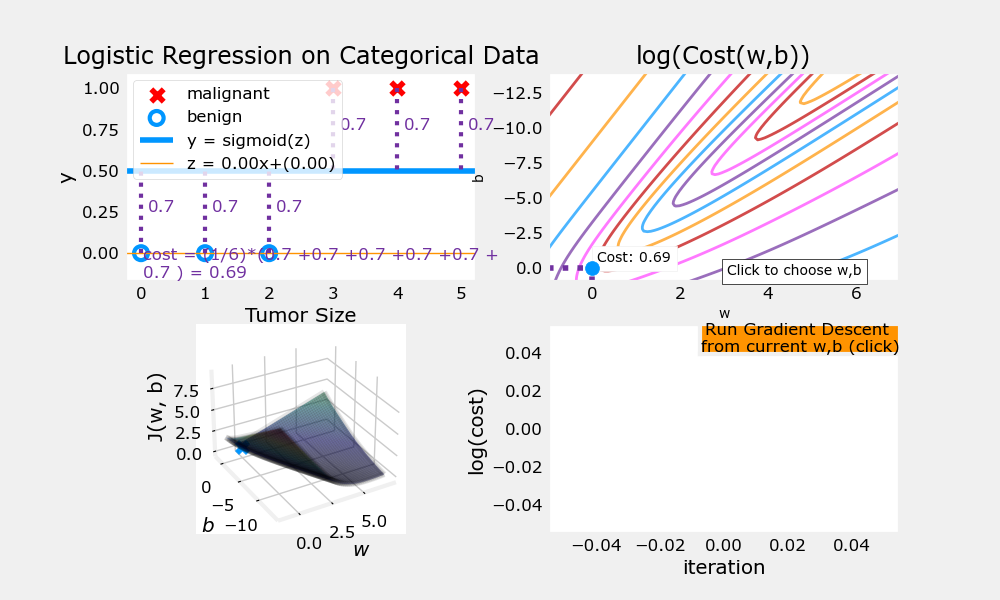

In [12]:
w_range = np.array([-1, 7])
b_range = np.array([1, -14])
quad = plt_quad_logistic( x_train, y_train, w_range, b_range )

## Congratulations!
당신은:
- 로지스틱 회귀에 대한 기울기 계산 공식 및 구현을 검토했습니다.
- 이러한 루틴을 활용했습니다.
     - 단일 변수 데이터 세트 탐색
     - 두 개의 변수가 있는 데이터 세트 탐색